<img src="https://gateway.dask.org/_static/images/dask-horizontal-white.svg"
     alt="Dask Logo"
     style="margin-right: 10px; width: 50%" />
# Distributed computing with Dask

EODC offers Dask as service by utilising [Dask Gateway](https://gateway.dask.org/). User can launch a Dask cluster in a shared and managed cluster environment without requring to have direct access to any cloud infrastructure resources such as VMs or Kubernetes clusters. The objetive is to lower the entrance barrier for users to run large scale data analysis on demand and in a scaleable environment.

An generic introduction of the usage of Dask Gateway can be found on the official [Dask Gateway documentation](https://gateway.dask.org/usage.html). In the following we will demonstrate the use of the Dask service at EODC to further support users.

Pre-requisit is to have Dask Gateway installed in your environment
```bash
pip install dask-gateway
```
or 
```bash
conda install -c conda-forge dask-gateway
```

It is important to note that the Python environment running the code and the environment utilised by Dask Gateway have to be almost identical.

We will install some additional packages used in this demo afterwards.

## Authentication via OIDC password grant flow
Only authenticated access is granted to the EODC Dask service, therefore a helper class to authenticate a user against the EODC identifiy managment system is implemented in the [EODC SDK](https://github.com/eodcgmbh/eodc-sdk).
The users password is directly handed over to the request object and is not stored.
Refreshed token is used to request a new access token in case it is expired, which is handled automatically in the authenticator.

## Connect to EODC Dask

Authenticating and connecting to EODC Dask can be done with a few lines of Python code.

Run the following in order to make sure all dependencies are met.

In [1]:
from eodc.dask import EODCDaskGateway
from rich.console import Console
from rich.prompt import Prompt
console = Console()
your_username = Prompt.ask(prompt="Enter your Username")
gateway = EODCDaskGateway(username=your_username)

Enter your Username:

## Change Cluster configuration if needed

In [2]:
cluster_options = gateway.cluster_options()
cluster_options

Options<worker_cores=2,
        worker_memory=2.0,
        image='registry.eodc.eu/eodc/clusters/dedl-deployment/dedl-dask:2023.08.3'>


## Create a Dask Cluster

Now we are going to create a Dask Cluster in order to run compute jobs.
To communicate with the cluster we have to instantiate a client as well.
Per default, no worker nodes are spawned, but this can be done either manually or even by enabling adaptive scaling of the cluster.

**Important: Please use the widget to add/scale the Dask workers. Per default no worker is spawned, therefore no computations can be performed by the cluster.**

In [3]:
cluster = gateway.new_cluster(cluster_options)
client = cluster.get_client()
cluster

/home/tsarinho/Repos/dask-flood-mapper/dask-flood-mapper/.venv/lib/python3.10/site-packages/distributed/client.py:1401: VersionMismatchWarning: Mismatched versions found

+---------+-----------------+----------------+---------+
| Package | Client          | Scheduler      | Workers |
+---------+-----------------+----------------+---------+
| dask    | 2024.7.0        | 2023.8.0       | None    |
| msgpack | 1.1.0           | 1.0.5          | None    |
| python  | 3.10.12.final.0 | 3.11.4.final.0 | None    |
| toolz   | 1.0.0           | 0.12.0         | None    |
+---------+-----------------+----------------+---------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


2025-02-24 09:06:18,694 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


If you want to spawn a workers directly via Python adaptively please use the following method call. With the following the cluster will be scaled to 2 workers initially.
Depending on the load, Dask will add addtional workers, up to 5, if needed.

In [4]:
cluster.adapt(minimum=2, maximum=5)

## List clusters if available

In [5]:
console.print(gateway.list_clusters())

[ClusterReport<name=dask-gateway.50aa991596c6427a8668d1a52ed61fdb, status=RUNNING>]

We can connect to already running clusters again.

In [6]:
cluster = gateway.connect(gateway.list_clusters()[0].name)
console.print(cluster)

GatewayCluster<dask-gateway.50aa991596c6427a8668d1a52ed61fdb, status=running>

## Display Dask Dashboard to monitor execution of computations
Copy the following link into a browser of your choice. Please consider the dashboard url provided is making use of http and not https.

In [7]:
cluster.dashboard_link

'http://dask.dev.services.eodc.eu/clusters/dask-gateway.50aa991596c6427a8668d1a52ed61fdb/status'

In [8]:
import s3fs
import xarray as xr

s3fs_central = s3fs.S3FileSystem(
    anon=True,
    use_ssl=True,
    client_kwargs={"endpoint_url": "https://s3.central.data.destination-earth.eu"})

s3fs_lumi = s3fs.S3FileSystem(
    anon=True,
    use_ssl=True,
    client_kwargs={"endpoint_url": "https://s3.lumi.data.destination-earth.eu"})

In [9]:
s3fs_central.ls("increment1-testdata")

['increment1-testdata/2022-08-30.zarr', 'increment1-testdata/built_data.zarr']

Read data stored in S3 bucket at central site (Poland).
The data we want to read is a single Zarr data store representing GFM flood data over Pakistan for 2022-08-30

In [10]:
flood_map = xr.open_zarr(store=s3fs.S3Map(root=f"increment1-testdata/2022-08-30.zarr", s3=s3fs_central, check=False),
                         decode_coords="all",)["flood"].assign_attrs(location="central", resolution=20)
flood_map

<xarray.DataArray 'flood' (y: 49270, x: 38697)>
dask.array<open_dataset-flood, shape=(49270, 38697), dtype=float32, chunksize=(1000, 1000), chunktype=numpy.ndarray>
Coordinates:
    spatial_ref  int64 ...
  * x            (x) float64 64.83 64.83 64.83 64.83 ... 71.88 71.88 71.88 71.88
  * y            (y) float64 30.4 30.4 30.4 30.4 ... 21.41 21.41 21.41 21.41
Attributes:
    tiles:       ['E015N024T3', 'E015N027T3', 'E015N030T3', 'E018N027T3', 'E0...
    location:    central
    resolution:  20

Run simple computation and compute the flooded area

In [11]:
flooded_area_ = flood_map.sum()*20*20/1000.
flooded_area_

<xarray.DataArray 'flood' ()>
dask.array<truediv, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    spatial_ref  int64 ...

So far we haven't computed anything, so lets do the computation now on the Dask cluster.

In [12]:
flooded_area = client.compute(flooded_area_, sync=True)
console.print(f"Flooded area: {flooded_area.data}km2")

Flooded area: 18991614.0km2

Read data stored in S3 bucket at LUMI bridge (Finland).
Data we want to read is a datacube generated from ERA-5 representing predicted rainfall data.

In [13]:
rainfall = xr.open_zarr(store=s3fs.S3Map(root=f"increment1-testdata/predicted_rainfall.zarr",
                                         s3=s3fs_lumi,
                                         check=False),
                        decode_coords="all",)["tp"].assign_attrs(location="lumi", resolution=20)
rainfall

<xarray.DataArray 'tp' (time: 3288, latitude: 1801, longitude: 3600)>
dask.array<open_dataset-tp, shape=(3288, 1801, 3600), dtype=float32, chunksize=(100, 100, 100), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 90.0 89.9 89.8 89.7 ... -89.8 -89.9 -90.0
  * longitude  (longitude) float64 -180.0 -179.9 -179.8 ... 179.7 179.8 179.9
  * time       (time) datetime64[ns] 2015-01-01 2015-01-02 ... 2024-01-01
Attributes:
    location:    lumi
    resolution:  20

In [14]:
from datetime import datetime
from attr import dataclass

def accum_rain_predictions(rain_data, startdate, enddate, extent):
    rain_ = rain_data.sel(time=slice(startdate, enddate),
                          latitude=slice(extent.max_y, extent.min_y),
                          longitude=slice(extent.min_x, extent.max_x))
    return rain_.cumsum(dim="time", keep_attrs=True)*1000

@dataclass
class Extent:
    min_x: float
    min_y: float
    max_x: float
    max_y: float
    crs: str

# compute accumulated rainfall over Pakistan
roi_extent = Extent(65, 21, 71, 31, crs='EPSG:4326')
acc_rain_ = accum_rain_predictions(rainfall, startdate=datetime(2022, 8, 18),
                                             enddate=datetime(2022, 8, 30),
                                             extent=roi_extent)

# compute average rainfall for August 2022
rain_ = rainfall.sel(time=slice(datetime(2022, 8, 1), datetime(2022, 8, 30))).mean(dim="time", keep_attrs=True)*1000
rain_

<xarray.DataArray 'tp' (latitude: 1801, longitude: 3600)>
dask.array<mul, shape=(1801, 3600), dtype=float32, chunksize=(100, 100), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 90.0 89.9 89.8 89.7 ... -89.8 -89.9 -90.0
  * longitude  (longitude) float64 -180.0 -179.9 -179.8 ... 179.7 179.8 179.9

And again run the computation on our EODC Dask cluster.
First we compute the accumulated rainfall over Pakistan.
Secondly we compute the average rainfall for August 2022 (monthly mean) at global scale.

In [15]:
acc_rain = client.compute(acc_rain_, sync=True)
acc_rain
mean_rain = client.compute(rain_, sync=True)
mean_rain

<xarray.DataArray 'tp' (latitude: 1801, longitude: 3600)>
array([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [5.928745 , 5.929659 , 5.9305854, ..., 5.9251294, 5.9263253,
        5.9275312],
       [5.935259 , 5.935921 , 5.936606 , ..., 5.932574 , 5.9334736,
        5.934352 ],
       [6.220585 , 6.220585 , 6.220585 , ..., 6.220585 , 6.220585 ,
        6.220585 ]], dtype=float32)
Coordinates:
  * latitude   (latitude) float64 90.0 89.9 89.8 89.7 ... -89.8 -89.9 -90.0
  * longitude  (longitude) float64 -180.0 -179.9 -179.8 ... 179.7 179.8 179.9

Plot a histogram of the accumlated rainfall computed for Pakistan.

(array([40807., 13371., 10154.,  6996.,  3706.,  1690.,   666.,   341.,
          197.,    72.]),
 array([   0.        ,  608.03198242, 1216.06396484, 1824.09594727,
        2432.12792969, 3040.15991211, 3648.19189453, 4256.22363281,
        4864.25585938, 5472.28808594, 6080.31982422]),
 <BarContainer object of 10 artists>)

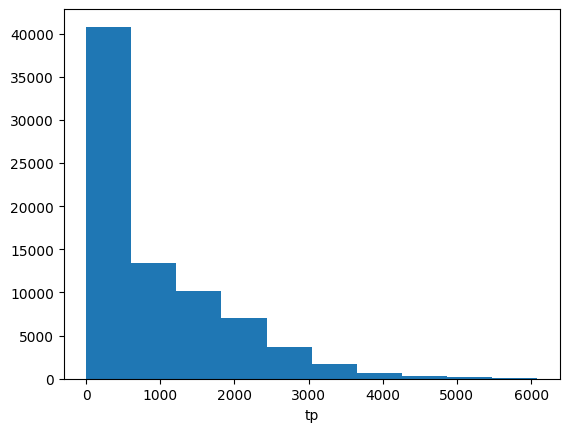

In [16]:
acc_rain.plot()

In [17]:
cluster.close(shutdown=True)